**Implementing Label Propagation with Self-Training**

In [1]:
from abc import ABCMeta, abstractmethod
import warnings
import numpy as np
from scipy import sparse
from scipy.sparse import csgraph
from sklearn import base,metrics,neighbors,utils,exceptions
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import ConvergenceWarning
from sklearn import datasets
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
"""
  The base_LabelPropagation class is an implementation of the LabelPropagation algorithm for semi-supervised learning.
  It serves as the base class for label propagation models and provides the core functionality for propagating labels from labeled to unlabeled data points.
  The base_LabelPropagation class provides a foundation for implementing label propagation models
  and can be extended to customize specific variants of the algorithm.
"""
class base_LabelPropagation(ClassifierMixin,BaseEstimator):
  def __init__(
        self,
        kernel="knn",
        *,
        gamma=20,
        n_neighbors=7,
        alpha=0.8,
        max_iter=30,
        tol=1e-3,
        n_jobs=None,
    ):

        self.max_iter = max_iter
        self.tol = tol

        # kernel parameters
        self.kernel = kernel
        self.gamma = gamma
        self.n_neighbors = n_neighbors

        # clamping factor
        self.alpha = alpha
        self.n_jobs = n_jobs

  def _get_kernel(self, X, y=None):
    if self.kernel == "knn":
          if self.nn_fit is None:
              self.nn_fit = NearestNeighbors(
                  n_neighbors=self.n_neighbors, n_jobs=self.n_jobs
              ).fit(X)
          if y is None:
              return self.nn_fit.kneighbors_graph(
                  self.nn_fit._fit_X, self.n_neighbors, mode="connectivity"
              )
          else:
              return self.nn_fit.kneighbors(y, return_distance=False)

  def _build_graph(self):

        #Graph matrix for Label Propagation computes the graph laplacian
        if self.kernel == "knn":
            self.nn_fit = None
        n_samples = self.X_.shape[0]
        affinity_matrix = self._get_kernel(self.X_)
        #Compute affinity matrix (or gram matrix)
        laplacian = csgraph.laplacian(affinity_matrix, normed=True)
        laplacian = -laplacian
        if sparse.isspmatrix(laplacian):
            diag_mask = laplacian.row == laplacian.col
            laplacian.data[diag_mask] = 0.0
        else:
            laplacian.flat[:: n_samples + 1] = 0.0
        return laplacian

  def predict(self, X):
          probas = self.predict_probability(X)
          return self.classes_[np.argmax(probas, axis=1)].ravel()

  def predict_probability(self, X):
    check_is_fitted(self)

    X_2d = self._validate_data(
        X,
        accept_sparse=["csc", "csr", "coo", "dok", "bsr", "lil", "dia"],
        reset=False,
    )
    weight_matrices = self._get_kernel(self.X_, X_2d)
    if self.kernel == "knn":
        probabilities = np.array(
            [
                np.sum(self.label_distributions_[weight_matrix], axis=0)
                for weight_matrix in weight_matrices
            ]
        )
    else:
        weight_matrices = weight_matrices.T
        probabilities = safe_sparse_dot(weight_matrices, self.label_distributions_)
    normalizer = np.atleast_2d(np.sum(probabilities, axis=1)).T
    probabilities /= normalizer
    return probabilities


  def fit(self, X, y):

      X, y = self._validate_data(X, y)
      self.X_ = X
      check_classification_targets(y)
      graph_matrix = self._build_graph()

    # construct a categorical distribution for classification only
      classes = np.unique(y)
      classes = classes[classes != -1]
      self.classes_ = classes
      n_samples, n_classes = len(y), len(classes)
      alpha = self.alpha
      y = np.asarray(y)
      unlabeled = y == -1

      # initialize distributions
      self.label_distributions_ = np.zeros((n_samples, n_classes))
      for label in classes:
          self.label_distributions_[y == label, classes == label] = 1

      y_static = np.copy(self.label_distributions_)
      y_static[unlabeled] = 0

      l_previous = np.zeros((self.X_.shape[0], n_classes))
      unlabeled = unlabeled[:, np.newaxis]
      if sparse.isspmatrix(graph_matrix):
          graph_matrix = graph_matrix.tocsr()

      for self.n_iter_ in range(self.max_iter):
          if np.abs(self.label_distributions_ - l_previous).sum() < self.tol:
              break
          l_previous = self.label_distributions_
          self.label_distributions_ = safe_sparse_dot(
              graph_matrix, self.label_distributions_
          )

          normalizer = np.sum(self.label_distributions_, axis=1)[:, np.newaxis]
          normalizer[normalizer == 0] = 1
          self.label_distributions_ /= normalizer
          self.label_distributions_ = np.where(
              unlabeled, self.label_distributions_, y_static
          )

      else:
          warnings.warn(
              "max_iter=%d was reached without convergence." % self.max_iter,
              category=ConvergenceWarning,
          )
          self.n_iter_ += 1

      normalizer = np.sum(self.label_distributions_, axis=1)[:, np.newaxis]
      normalizer[normalizer == 0] = 1
      self.label_distributions_ /= normalizer

      # setting transduction
      transduction = self.classes_[np.argmax(self.label_distributions_, axis=1)]
      self.transduction_ = transduction.ravel()
      return self


In [44]:
"""This function performs label propagation on a dataset using the LabelPropagation algorithm.
   It takes the number of labeled points as input and applies label propagation to predict labels for the remaining unlabeled points.
   The function provides insights into the performance of label propagation and demonstrates learning with a small amount of labeled data.
"""
def propagation_Function(nlabeledpoints):

  digits = datasets.load_digits()
  rng = np.random.RandomState(0)
  indices = np.arange(len(digits.data))

  rng.shuffle(indices)

  X = digits.data[indices[:330]]
  y = digits.target[indices[:330]]
  images = digits.images[indices[:330]]

  ntotalsamples = len(y)
  #nlabeledpoints = 10
  y_train = np.copy(y)
  indices = np.arange(ntotalsamples)
  training_index = indices[:nlabeledpoints]
  unlabeled_set = indices[nlabeledpoints:]

  # Shuffle everything around
  y_train[unlabeled_set] = -1

  label_prop_model = base_LabelPropagation()
  label_prop_model.fit(X,y_train)

  predicted_labels = label_prop_model.predict(X[unlabeled_set])
  true_labels = y[unlabeled_set]

  cm = confusion_matrix(true_labels, predicted_labels)
  print("Confusion Matrix : \n",cm)
  print("Classification Report : \n",classification_report(true_labels, predicted_labels))


  print(
      "Label Spreading model: %d labeled & %d unlabeled points (%d total)"
      % (nlabeledpoints, ntotalsamples - nlabeledpoints, ntotalsamples)
  )




  # Calculate uncertainty values for each transduced distribution
  pred_entropies = stats.distributions.entropy(label_prop_model.label_distributions_.T)

  # Pick the top 5 most uncertain labels
  uncertainty_index = np.argsort(pred_entropies)[:5]

  f = plt.figure(figsize=(10, 6))
  for index, image_index in enumerate(uncertainty_index):
      image = images[image_index]

      sub = f.add_subplot(2, 5, index + 1)
      sub.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest', vmin=0, vmax=16)
      plt.xticks([])
      plt.yticks([])
      sub.set_title(
          "predict: %i\ntrue: %i" % (label_prop_model.transduction_[image_index], y[image_index])
      )

  f.suptitle("Learning with small amount of labeled data")
  plt.show()

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
<ipython-input-4-b44cbfc9507d>:80: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-d

Confusion Matrix : 
 [[ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  9  3 12  0]
 [ 0  0 29  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0 13  0  0  0 22]
 [ 0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  1  0 30  2]
 [ 0  0  0  0  0  3  0  3  0 31]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        29
           2       0.83      0.94      0.88        31
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        27
           5       0.81      0.37      0.51        35
           6       0.80      1.00      0.89        40
           7       0.51      1.00      0.67        36
           8       0.71      0.91      0.80        33
           9       0.38      0.84      0.52        37

    accuracy              

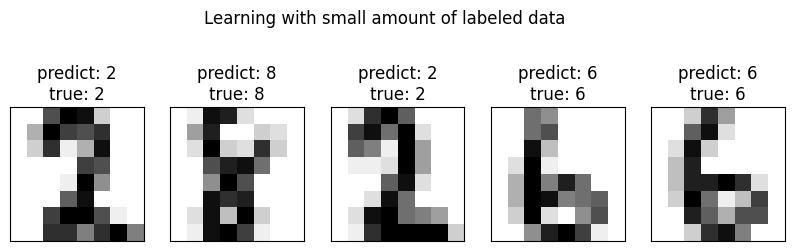

In [45]:
propagation_Function(nlabeledpoints=10)

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
<ipython-input-4-b44cbfc9507d>:80: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-d

Confusion Matrix : 
 [[ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  9  3 12  0]
 [ 0  0 29  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0 13  0  0  0 22]
 [ 0  0  0  0  0  0 40  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  1  0 30  2]
 [ 0  0  0  0  0  3  0  3  0 31]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        29
           2       0.83      0.94      0.88        31
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        27
           5       0.81      0.37      0.51        35
           6       0.80      1.00      0.89        40
           7       0.51      1.00      0.67        36
           8       0.71      0.91      0.80        33
           9       0.38      0.84      0.52        37

    accuracy              

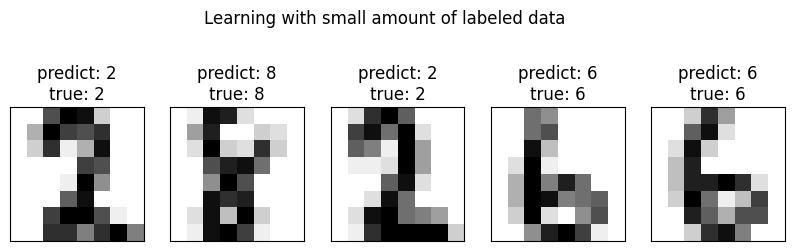

In [46]:
propagation_Function(nlabeledpoints=10)

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
<ipython-input-4-b44cbfc9507d>:80: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-d

Confusion Matrix : 
 [[ 0 24  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0 11  1 12  0]
 [ 0  0 28  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0 13  0  0  0 22]
 [ 0  0  0  0  0  0 37  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  1  0 29  2]
 [ 0  0  0  0  0  3  0  3  0 31]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.00      0.00      0.00        29
           2       0.82      0.93      0.87        30
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        27
           5       0.81      0.37      0.51        35
           6       0.76      1.00      0.86        37
           7       0.52      1.00      0.69        36
           8       0.71      0.91      0.79        32
           9       0.38      0.84      0.52        37

    accuracy              

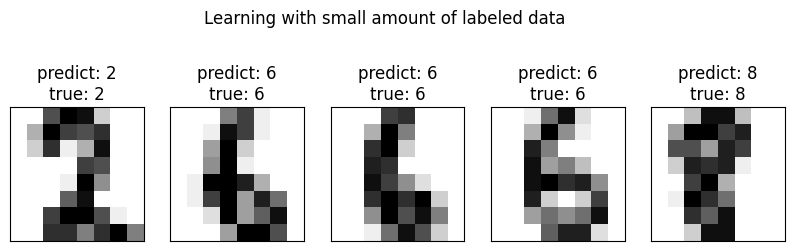

In [47]:
propagation_Function(nlabeledpoints=15)

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

Confusion Matrix : 
 [[23  0  0  0  0  0  0  0  0  0]
 [ 0 12  5  0  0  0  0  0 11  0]
 [ 1  0 27  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0 27]
 [ 0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0 22  0  0  0 12]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  1  0 30  0]
 [ 1  2  0  0  0  3  0  1  0 30]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.86      0.43      0.57        28
           2       0.82      0.90      0.86        30
           3       0.00      0.00      0.00        28
           4       0.00      0.00      0.00        27
           5       0.88      0.65      0.75        34
           6       0.97      1.00      0.99        36
           7       0.55      1.00      0.71        36
           8       0.73      0.97      0.83        31
           9       0.43      0.81      0.57        37

    accuracy              

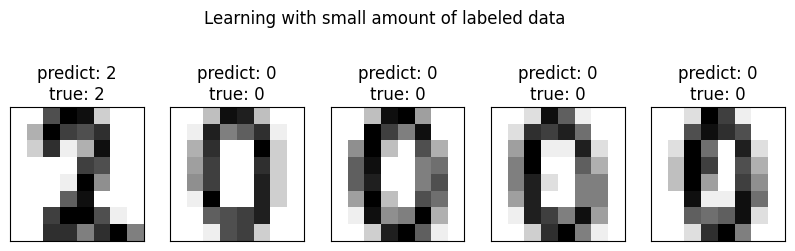

In [48]:
propagation_Function(nlabeledpoints=20)

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

Confusion Matrix : 
 [[23  0  0  0  0  0  0  0  0  0]
 [ 0 12  5  0  0  0  0  0 11  0]
 [ 1  0 27  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0 27  0]
 [ 0  0  0  0 25  0  0  1  0  0]
 [ 0  0  0  0  0 22  0  0  0 12]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  1  0 28  0]
 [ 1  1  0  0  1  3  0  1  1 29]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.92      0.43      0.59        28
           2       0.82      0.90      0.86        30
           3       0.00      0.00      0.00        28
           4       0.96      0.96      0.96        26
           5       0.88      0.65      0.75        34
           6       0.97      1.00      0.99        36
           7       0.89      1.00      0.94        34
           8       0.42      0.97      0.58        29
           9       0.71      0.78      0.74        37

    accuracy              

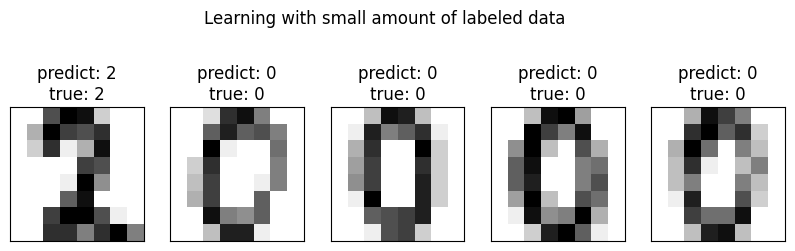

In [49]:
propagation_Function(nlabeledpoints=25)

<ipython-input-4-b44cbfc9507d>:129: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

Confusion Matrix : 
 [[23  0  0  0  0  0  0  0  0  0]
 [ 0 12  5  0  0  0  0  0 11  0]
 [ 1  0 26  0  0  0  0  2  0  0]
 [ 0  0  1  0  0  0  0  0  0 27]
 [ 0  0  0  0 24  0  0  1  0  0]
 [ 0  0  0  0  0 22  0  0  0 11]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 34  0  0]
 [ 0  0  0  0  0  0  1  0 26  2]
 [ 1  1  0  0  1  3  0  0  0 29]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        23
           1       0.92      0.43      0.59        28
           2       0.81      0.90      0.85        29
           3       0.00      0.00      0.00        28
           4       0.96      0.96      0.96        25
           5       0.88      0.67      0.76        33
           6       0.97      1.00      0.99        36
           7       0.92      1.00      0.96        34
           8       0.70      0.90      0.79        29
           9       0.42      0.83      0.56        35

    accuracy              

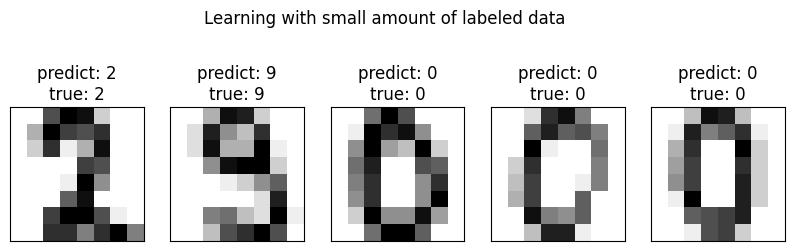

In [50]:
propagation_Function(nlabeledpoints=30)